# Example 2: Spectrograms of detected vocalizations

In this notebook we will

* Load vocalization intervals detected in Example 1

* Compute spectrograms for all intervals detected and temporally align them to center of mass

In [1]:
import sys
sys.path.append("../code/soundsep")

In [2]:
import time

import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import umap
from IPython.display import clear_output, Audio, display
from sklearn.decomposition import PCA
from soundsig.sound import plot_spectrogram, spectrogram
from soundsig.signal import bandpass_filter

from audio_utils import get_amplitude_envelope
from interfaces.audio import LazyWavInterface
from plotting_utils import MultiChannelPlotter, MultiSpecPlotter

%load_ext autoreload
%autoreload 2

## 1. Load the data

We will be using the same audio file used in the notebook Example 1, `example.wav`. In addition, we will load the vocalization intervals we found, saved in `example_intervals.npy`.

In [3]:
audio_signal = LazyWavInterface("example.wav", dtype=np.float64)

In [4]:
intervals = np.load("example_intervals.npy")[()]

###  Let's check a couple just to make sure they are okay.

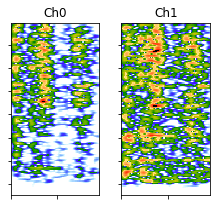

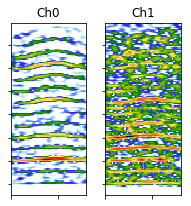

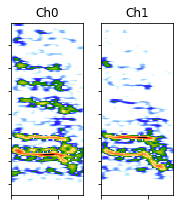

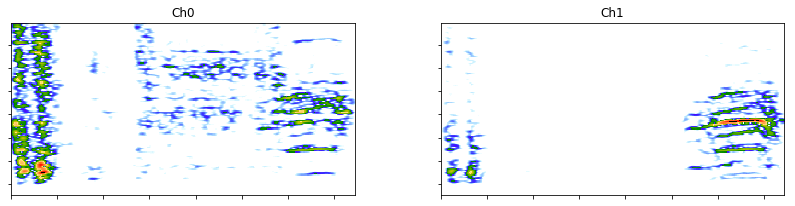

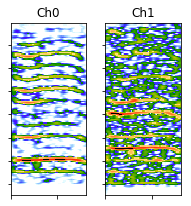

In [5]:
NUM_EXAMPLES = 5
random_indexes = np.random.choice(np.arange(len(intervals)), size=NUM_EXAMPLES, replace=False)
for randind in random_indexes:
    t1, t2 = intervals[randind]
    
    t_arr, sig = audio_signal.time_slice(t1, t2)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    
    specs = []
    for ch in range(sig.shape[1]):
        t_spec, f_spec, spec, _ = spectrogram(
            sig[:, ch],
            audio_signal.sampling_rate,
            1000,
            50,
            min_freq=500,
            max_freq=8000,
            cmplx=False
        )
        specs.append((t_spec, f_spec, spec))
    width = (t2 - t1) * 16
    plotter = MultiSpecPlotter(
        specs,
        panel_size=(width, 3),
        layout="horizontal",
        colorbar=False,
        dBNoise=30,
    )
    for ax_idx in range(len(plotter.axes)):
        plotter.axes[ax_idx].set_title("Ch{}".format(ax_idx))
    plotter.plot()
    
    # Play the audio with a 10ms buffer on each side
    t_arr, sig = audio_signal.time_slice(t1 - 0.01, t2 + 0.01)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    display(Audio(sig[:, 0], rate=audio_signal.sampling_rate, normalize=False))
    display(Audio(sig[:, 1], rate=audio_signal.sampling_rate, normalize=False))

## 2. Collect all the spectrograms to cluster on

Each call can be a different length. This makes it hard to cluster when you usually need data that is the same shape every time.

To find the initial embedding and do a rough clustering, we will first compute amplitude envelopes for EVERY INTERVAL, and find their "center of mass" - what time the power in that vocalization or sound is centered at.

Then we will take a 0.5s time period around the center of mass and use that as the representative datapoint for clustering.

In [6]:
centers_of_mass = []
all_call_spectrograms = []
all_calls = []

_time = time.time()

for idx, (t1, t2) in enumerate(intervals):
    print("Working on {}/{} ({:.2f}s elapsed)".format(idx + 1, len(intervals), time.time() - _time), end="\r")
    
    # Recentered signal with a small buffer of 40ms on either side
    buffer = 0.01
    t_arr, sig = audio_signal.time_slice(t1 - buffer, t2 + buffer)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    
    amp_env = get_amplitude_envelope(sig, fs=audio_signal.sampling_rate,
                                     lowpass=8000, highpass=1000)
    
    # Compute the temporal center of mass of the signal
    center_of_mass = t1 - buffer + np.sum((t_arr * np.sum(amp_env, axis=1))) / np.sum(amp_env)
    
    # Recentered signal with a small buffer of 40ms on either side
    buffer = 0.04
    t_arr, sig = audio_signal.time_slice(center_of_mass - buffer, center_of_mass + buffer)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    
    specs = []
    all_calls.append(sig)
    for ch in range(sig.shape[1]):
        # Sligtly lower resolution on the spectrograms can make this go faster
        # Can increase the params to 1000, 50 for a higher resolution spectrogram
        _, _, spec, _ = spectrogram(
            sig[:, ch],
            audio_signal.sampling_rate,
            1000,
            50,
            min_freq=1000,
            max_freq=8000,
            cmplx=False
        )
        specs.append(spec)
        
    all_call_spectrograms.append(np.array(specs))
    
all_call_spectrograms = np.array(all_call_spectrograms)     
all_calls = np.array(all_calls)

## 3. Save the spectrograms to a file

In [7]:
np.save("example_spectrograms.npy", all_call_spectrograms)

In [8]:
np.save("example_calls.npy", all_calls)